In [35]:
import numpy as np
import os

In [36]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [37]:
import PIL
from PIL import Image
import tensorflow as tf
import random
import re
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
#disable_eager_execution()
enable_eager_execution()

In [38]:
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN

In [39]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow_datasets as tfds

In [40]:
from __future__ import print_function
import argparse
from tensorflow.keras.layers import Input
import scipy.misc

from configs import bcolors
from utils import *
import tensorflow_model_optimization as tfmot

In [41]:
from keras_vggface.vggface import VGGFace
from keras.engine import  Model
from keras.layers import Input
from keras.preprocessing import image
from keras.layers import Flatten, Dense, Input
from keras_vggface import utils

In [42]:
import tarfile
from IPython.display import Image
import keras_vggface

In [43]:
from livelossplot import PlotLossesKeras

In [44]:
from collections import Counter
import json

In [45]:
def preprocess_input(x):
    x_temp = np.copy(x)
    x_temp = x_temp[..., ::-1]
    x_temp[..., 0] -= 91.4953
    x_temp[..., 1] -= 103.8827
    x_temp[..., 2] -= 131.0912
    return x_temp

In [46]:
def deprocess_input(x):
    x_temp = np.copy(x)
    x_temp[..., 0] += 91.4953
    x_temp[..., 1] += 103.8827
    x_temp[..., 2] += 131.0912
    x_temp = x_temp[..., ::-1]
    return x_temp

# Load PubFig subset

In [47]:
H,W= 224, 224

In [14]:
def loadimgs(path,n = 0):
    H,W= 224, 224
    curr_y = n
    person_dict={}
    c=0
    for person in os.listdir(path):
        #print("loading person: "+person)
        person_path = os.path.join(path,person)
        person_images=[]
        for name in os.listdir(person_path):
            image_path=os.path.join(person_path,name)
            pixels = pyplot.imread(image_path)
            image = tf.image.resize(pixels,[H,W]).numpy()
            samples = preprocess_input(image)
            person_images.append(samples)
        person_dict[person]=np.stack(person_images)
    return person_dict

In [132]:
np.max(labels),np.min(labels), np.mean(labels), np.sum(labels)

(403, 7, 77.6, 11640)

In [63]:
len(train_y)

7551

np.save('/local/rcs/wei/pubface/CelebDataProcessed/test_x.npy',np.array(test_x))
np.save('/local/rcs/wei/pubface/CelebDataProcessed/test_y.npy',np.array(test_y))

In [48]:
import json
# Opening JSON file
f = open("/local/rcs/wei/pubface/identities_decoder.json",)
  
# returns JSON object as 
# a dictionary
decode  = json.load(f)

In [49]:
test_x,test_y = np.load('/local/rcs/wei/pubface/test_x.npy'),np.load('/local/rcs/wei/pubface/test_y.npy')

In [50]:
train_x,train_y = np.load('/local/rcs/wei/pubface/train_x.npy'),np.load('/local/rcs/wei/pubface/train_y.npy')

# Load LFW

In [37]:
import json
# Opening JSON file
f = open("/local/rcs/wei/FR/identities_decoder.json",)
  
# returns JSON object as 
# a dictionary
decode  = json.load(f)

In [52]:
x = np.load('/local/rcs/wei/FR/LFW_images.npy',allow_pickle=True)

In [44]:
y = np.load('/local/rcs/wei/FR/LFW_labels_int.npy',allow_pickle=True)

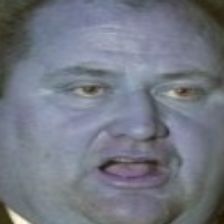

b'Tom_Amstutz'


In [45]:
pil_img = tf.keras.preprocessing.image.array_to_img(x[0])
display(pil_img)
print(decode[str(y[0])])

In [47]:
y.shape

(13175,)

In [73]:
class_info = Counter(y)

<BarContainer object of 5729 artists>

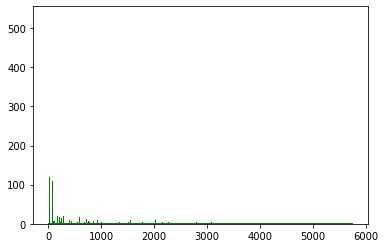

In [74]:
width = 1.0
plt.bar(class_info.keys(), class_info.values(), width, color='g')

In [75]:
max(class_info.values()),min(class_info.values()), np.mean(list(class_info.values())), np.std(list(class_info.values()))

(529, 1, 2.2997032640949553, 9.002709096499778)

In [56]:
(x_train,y_train) = x[0:10000],y[0:10000]
(x_test,y_test) = x[10000:13175],y[10000:13175]

# Load Model

In [51]:
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace

In [70]:
vgg_model = VGGFace(include_top=False, input_shape=(224, 224, 3),model='resnet50')
last_layer = vgg_model.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
out = Dense(150, activation='softmax', name='classifier')(x)
fp_model = Model(vgg_model.input, out)

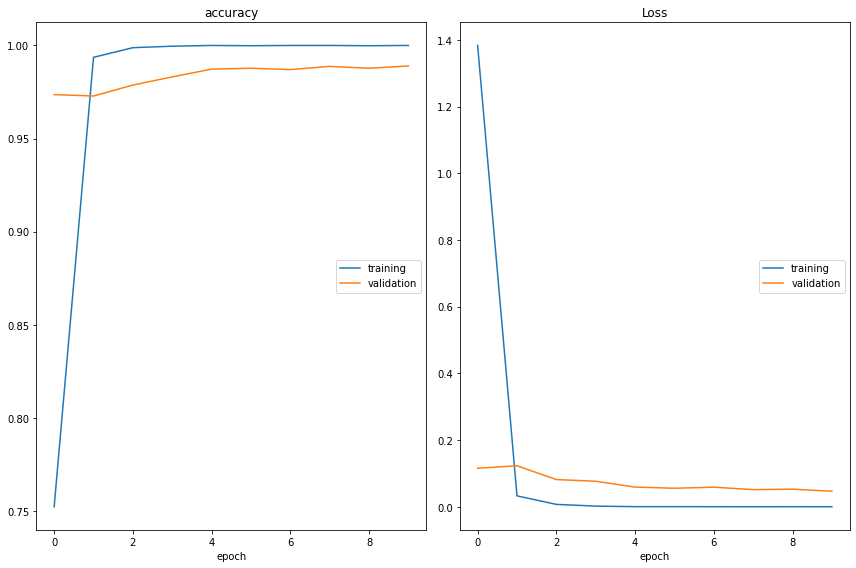

accuracy
	training         	 (min:    0.752, max:    1.000, cur:    1.000)
	validation       	 (min:    0.973, max:    0.989, cur:    0.989)
Loss
	training         	 (min:    0.000, max:    1.383, cur:    0.000)
	validation       	 (min:    0.047, max:    0.123, cur:    0.047)


In [92]:
#fp_model.fit(x=np.array(train_x),y=np.array(train_y),epochs =10,validation_data = (np.array(test_x),np.array(test_y)),callbacks=[PlotLossesKeras()])

In [94]:
#fp_model.save('./fp_model_65_pubface.h5')

In [71]:
q_model = tfmot.quantization.keras.quantize_model(fp_model)

In [54]:
q_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [72]:
vgg_model = VGGFace(include_top=False, input_tensor=q_model.input,model='resnet50')
last_layer = vgg_model.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
out = Dense(150, activation='softmax', name='classifier')(x)
fp_model = Model(q_model.input, out)

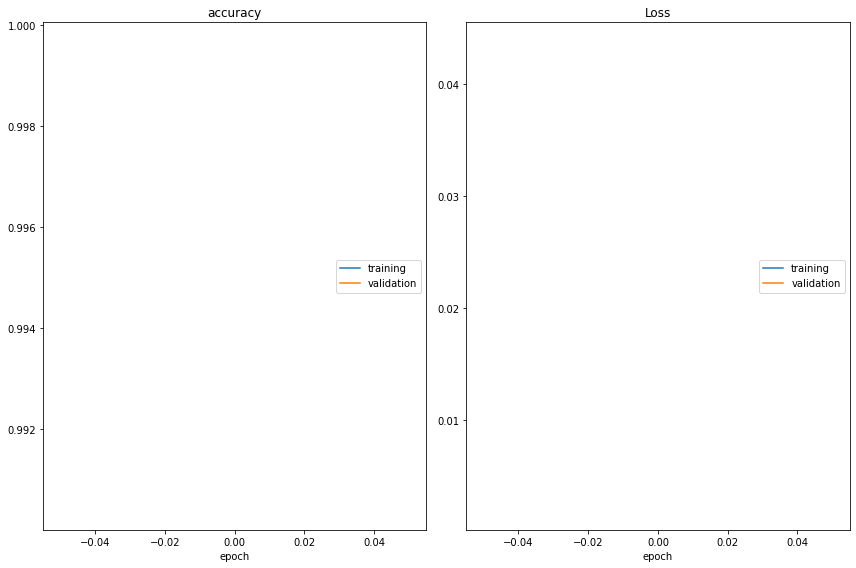

accuracy
	training         	 (min:    1.000, max:    1.000, cur:    1.000)
	validation       	 (min:    0.990, max:    0.990, cur:    0.990)
Loss
	training         	 (min:    0.002, max:    0.002, cur:    0.002)
	validation       	 (min:    0.043, max:    0.043, cur:    0.043)


In [101]:
#q_model.fit(x=np.array(train_x),y=np.array(train_y),epochs =1,validation_data = (np.array(test_x),np.array(test_y)),callbacks=[PlotLossesKeras()])

In [74]:
q_model.load_weights('./q_model_65_pubface.h5')
fp_model.load_weights('./fp_model_65_pubface.h5')
#q_model.save('./q_model_65_pubface.h5')

# our Attack

In [118]:
index = 1

In [119]:
image = deprocess_input(test_x[index])
orig_label = test_y[index]

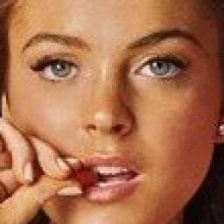

In [120]:
pil_img = tf.keras.preprocessing.image.array_to_img(image)
from IPython.display import Image
display(pil_img)

In [121]:
decode[str(orig_label)]

'Lindsay Lohan'

In [125]:
grad_iterations = 20
step = 1
epsilon = 8
A = 0
c = 1
model = fp_model

pred1, pred2= model.predict(preprocess_input(image)[None,...]), q_model.predict(preprocess_input(image)[None,...])
label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
if label1 != orig_label or label2 != label1:
    print("bad image")

input_image = tf.convert_to_tensor(image)
orig_img = tf.identity(input_image)
orig_logist = pred1

for iters in range(grad_iterations):
    with tf.GradientTape() as g:
        g.watch(input_image)
        print(orig_label)
        loss1 = K.mean(model(preprocess_input(input_image + A)[None,...], training = False)[..., orig_label])
        loss2 = K.mean(q_model(preprocess_input(input_image + A)[None,...], training = False)[..., orig_label])
        final_loss = loss1 - c*loss2

    grads = normalize(g.gradient(final_loss, input_image))

        # input_image += grads * step    
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = tf.clip_by_value(input_image  + A, 0, 255)
    test_image = preprocess_input(test_image_deprocess)[None,...]
            
    pred1, pred2= model.predict(test_image), q_model.predict(test_image)
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    if not label1 == label2:
        print("different")
        if label1 == orig_label and pred1[label1] > 0.6:
            print("Success!")
            A = test_image_deprocess - orig_image
            break

bad image
141


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

# Load Dataset

In [9]:
batch_size = 20
H, W, C = 224,224, 3

In [10]:
def preprocess_image(image, label):
    return tf.image.resize(image,[500,500]), label

In [11]:
data_ds_1 = tfds.load('vgg_face2', split='test[:10%]',data_dir='/local/rcs/asa97/vggface2/VGG-Face2/data/',as_supervised= True)

In [12]:
data_ds_2 = tfds.load('vgg_face2', split='test[-10%:]',data_dir='/local/rcs/asa97/vggface2/VGG-Face2/data/',as_supervised= True)

In [30]:
train_ds = data_ds_1.batch(1)

In [31]:
val_ds = data_ds_2.batch(1)

In [32]:
detector = MTCNN()

In [64]:
train_process = np.empty((H,W,C))
train_label = []
for i, images in enumerate(train_ds):
    index = 0
    if (i%1000) == 0:
        print(i)
    for image in images[0]:
        
        # detect faces in the image
        image_ = image.numpy().astype(np.uint8)
        results = detector.detect_faces(image_)
        if len(results) != 0:
            # extract the bounding box from the first face
            x1, y1, width, height = results[0]['box']
            x2, y2 = x1 + width, y1 + height
            # extract the face
            if x1 > 0 and y1 > 0 and width > 0 and height > 0:
                #print(x1, y1, width, height)
                face = image_[y1:y2, x1:x2]
                # resize pixels to the model size
                face_array = tf.image.resize(face,[H,W]).numpy()
                img_ = utils.preprocess_input(face_array[None,...])
                train_process = np.append(train_process, img_[0], axis=0)
                train_label.append(images[1][index].numpy())
        index += 1

0


KeyError: 0

In [ ]:
train_process.shape

In [ ]:
np.save('/local/rcs/wei/face/10p_train_x.npy',train_process)
np.save('/local/rcs/wei/face/10p_train_y.npy',numpy.array(train_label))

In [ ]:
train_process = np.empty((H,W,C))
train_label = []
for i, images in enumerate(val_ds):
    index = 0
    if (i%100) == 0:
        print(i)
    for image in images[0]:
        
        # detect faces in the image
        image_ = image.numpy().astype(np.uint8)
        results = detector.detect_faces(image_)
        if len(results) != 0:
            # extract the bounding box from the first face
            x1, y1, width, height = results[0]['box']
            x2, y2 = x1 + width, y1 + height
            # extract the face
            if x1 > 0 and y1 > 0 and width > 0 and height > 0:
                print(x1, y1, width, height)
                face = image_[y1:y2, x1:x2]
                # resize pixels to the model size
                face_array = tf.image.resize(face,[H,W]).numpy()
                img_ = utils.preprocess_input(face_array[None,...])
                train_process = np.append(train_process, img_[0], axis=0)
                train_label.append(images[1][index].numpy())
        index += 1

In [ ]:
np.save('/local/rcs/wei/face/10p_test_x.npy',train_process)
np.save('/local/rcs/wei/face/10p_test_y.npy',numpy.array(train_label))

## Load Model

In [23]:
from livelossplot import PlotLossesKeras

In [24]:
fp_model = VGGFace(model='resnet50', input_shape=(224, 224, 3))

In [27]:
for i ,a in enumerate(train_ds):
    images = a[0]
    break

In [46]:
detector = MTCNN()

In [ ]:
def train(batch_size, num_eppoch, model, ds):
    for n,features in enumerate(ds):
        images = features['image'].numpy()
        labels = features['label'].numpy()

In [57]:
class trainer(Model):
    def __init__(self, mymodel):
        super(trainer, self).__init__()
        self.mymodel = mymodel

    def compile(
        self,
        optimizer,
        metrics,
        model_loss_fn
    ):
        super(trainer, self).compile(optimizer=optimizer, metrics=metrics)
        self.model_loss_fn = model_loss_fn

    def train_step(self, data):
        # Unpack data
        x, y = data
        x_process = np.empty((H,W,C))
        for image in x:
            # detect faces in the image
            image_ = image.numpy().astype(np.uint8)
            results = detector.detect_faces(image_)
            # extract the bounding box from the first face
            x1, y1, width, height = results[0]['box']
            x2, y2 = x1 + width, y1 + height
            # extract the face
            face = image_[y1:y2, x1:x2]
            # resize pixels to the model size
            img = Image.fromarray(face)
            img = img.resize((H, W))
            face_array = np.asarray(img)
            img_ = utils.preprocess_input(face_array[None,...])
            x_process = np.append(x_process, img_[0], axis=0)

        with tf.GradientTape() as tape:
            # Forward pass of student
            mymodel_predictions = self.mymodel(x_process, training=True)

            # Compute losses
            loss = self.model_loss_fn(y, mymodel_predictions)

        # Compute gradients
        trainable_vars = self.mymodel.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"loss": loss}
        )
        return results
    
    def test_step(self, data):
        # Unpack the data
        x_process = np.empty((H,W,C))
        for image in x:
            # detect faces in the image
            image_ = image.numpy().astype(np.uint8)
            results = detector.detect_faces(image_)
            # extract the bounding box from the first face
            x1, y1, width, height = results[0]['box']
            x2, y2 = x1 + width, y1 + height
            # extract the face
            face = image_[y1:y2, x1:x2]
            # resize pixels to the model size
            img = Image.fromarray(face)
            img = img.resize((H, W))
            face_array = np.asarray(img)
            img_ = utils.preprocess_input(face_array[None,...])
            x_process = np.append(x_process, img_[0], axis=0)

        # Compute predictions
        y_prediction = self.mymodel(x_process, training=False)

        # Calculate the loss
        loss = self.model_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"loss": loss })
        return results

In [118]:
distiller = Distiller(student=fp_model, teacher=q_model_)
distiller.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    model_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

# Distill teacher to student
distiller.fit(train_ds, epochs=3)

In [119]:
fp_model.fit(train_ds,
          epochs=2)

Epoch 1/2


UnknownError: 2 root error(s) found.
  (0) Unknown:  LookupError: No gradient defined for operation 'IteratorGetNext' (op type: IteratorGetNext)
Traceback (most recent call last):

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/gradients_util.py", line 608, in _GradientsHelper
    grad_fn = ops.get_gradient_function(op)

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 2702, in get_gradient_function
    return _gradient_registry.lookup(op_type)

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/registry.py", line 98, in lookup
    raise LookupError(

LookupError: gradient registry has no entry for: IteratorGetNext


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 247, in __call__
    return func(device, token, args)

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 135, in __call__
    ret = self._func(*args)

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-107-81219c217952>", line 8, in preprocess_image
    results = detector.detect_faces(image.numpy())

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/mtcnn/mtcnn.py", line 302, in detect_faces
    result = stage(img, result[0], result[1])

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/mtcnn/mtcnn.py", line 342, in __stage1
    out = self._pnet.predict(img_y)

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py", line 1629, in predict
    tmp_batch_outputs = self.predict_function(iterator)

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 894, in _call
    return self._concrete_stateful_fn._call_flat(

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 1924, in _call_flat
    forward_function, args_with_tangents = forward_backward.forward()

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 1447, in forward
    forward_function = self._functions.forward(

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 1207, in forward
    self._forward_and_backward_functions(inference_args, input_tangents))

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 1358, in _forward_and_backward_functions
    return self._build_functions_for_outputs(

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 906, in _build_functions_for_outputs
    gradients_wrt_inputs = gradients_util._GradientsHelper(  # pylint: disable=protected-access

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/gradients_util.py", line 636, in _GradientsHelper
    raise LookupError(

LookupError: No gradient defined for operation 'IteratorGetNext' (op type: IteratorGetNext)


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
  (1) Unknown:  LookupError: No gradient defined for operation 'IteratorGetNext' (op type: IteratorGetNext)
Traceback (most recent call last):

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/gradients_util.py", line 608, in _GradientsHelper
    grad_fn = ops.get_gradient_function(op)

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 2702, in get_gradient_function
    return _gradient_registry.lookup(op_type)

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/registry.py", line 98, in lookup
    raise LookupError(

LookupError: gradient registry has no entry for: IteratorGetNext


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 247, in __call__
    return func(device, token, args)

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 135, in __call__
    ret = self._func(*args)

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-107-81219c217952>", line 8, in preprocess_image
    results = detector.detect_faces(image.numpy())

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/mtcnn/mtcnn.py", line 302, in detect_faces
    result = stage(img, result[0], result[1])

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/mtcnn/mtcnn.py", line 342, in __stage1
    out = self._pnet.predict(img_y)

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py", line 1629, in predict
    tmp_batch_outputs = self.predict_function(iterator)

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 894, in _call
    return self._concrete_stateful_fn._call_flat(

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 1924, in _call_flat
    forward_function, args_with_tangents = forward_backward.forward()

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 1447, in forward
    forward_function = self._functions.forward(

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 1207, in forward
    self._forward_and_backward_functions(inference_args, input_tangents))

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 1358, in _forward_and_backward_functions
    return self._build_functions_for_outputs(

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 906, in _build_functions_for_outputs
    gradients_wrt_inputs = gradients_util._GradientsHelper(  # pylint: disable=protected-access

  File "/home/wei.hao/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/gradients_util.py", line 636, in _GradientsHelper
    raise LookupError(

LookupError: No gradient defined for operation 'IteratorGetNext' (op type: IteratorGetNext)


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_7]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_2305430]

Function call stack:
train_function -> train_function


In [102]:
q_model = tfmot.quantization.keras.quantize_model(fp_model)

In [103]:
q_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [104]:
q_model.fit(train_ds,epochs=2)

Epoch 1/2
3278/3388 [============================>.] - ETA: 1:11 - loss: nan - accuracy: 0.0026

KeyboardInterrupt: 

In [ ]:
3q_model.save("./q_model_40_vggface.h5")